### End-to-End with Assembly.ai ###

### Input to Email ###

In [77]:
# !pip install wordcloud

In [78]:
#Data Manipulation
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
#Data Visualization
from chord import Chord
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Text manipulation
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.parsing.preprocessing import remove_stopwords
from rake_nltk import Rake
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

In [109]:
df

,Unnamed: 0,Speaker,Start,End,Sentences
0,0.0,A,0.443844,0.914656,This is William.
1,1.0,B,0.914656,4.757094,"Hey, again, London. This is David Miller. And ..."
2,2.0,A,7.210719,7.629219,NaN
3,3.0,B,8.754781,60.790531,The great thing about last night's general ele...
4,4.0,A,61.018344,120.811531,"The question is, how did the first election de..."
5,NaN,B,120.811531,129.000000,"I wear your blood around my neck,"" he captione..."
6,NaN,C,129.000000,136.000000,Fans may recall that Thornton and Jolie -- who...
7,NaN,D,136.000000,143.000000,I don't know.
8,NaN,A,143.000000,147.000000,We love each other.
9,NaN,C,147.000000,153.000000,What's your name?


In [105]:
df = pd.read_csv('0215_test - diar_df_v1.csv')

def feedback(df):
    # Preprocessing
    df = df[['Speaker', 'Start', 'End', 'Sentences']]
    df['talk_time'] = df['End'] - df['Start']
    df.fillna(' ', inplace=True)
    df['sentence_split'] = df['Sentences'].str.split('.')
    df['text_split'] = df['Sentences'].str.split()
    df['num_words_spoken'] = df['text_split'].str.len()
    df['word_per_sec'] = df['num_words_spoken']/df['talk_time']

    # Build the model to predict the most important sentence
    # nlp = spacy.load("en_core_web_sm")
    nlp = en_core_web_sm.load()

    # Create master transcript from df['Text']
    keywords = []
    for i in df['Sentences']:
        keywords.append(i)

    #Convert list to string
    keywords = ' '.join([str(item) for item in keywords])

    # Remove stopwords
    no_stop = remove_stopwords(keywords)

    #Create stopwords object
    doc = nlp(no_stop)

    #The sentence that best summarizes the conversation
    summary = summarize(keywords, ratio  = .1)
    summary = summary.split('.')[0]

    print(f"\nHeadline from Today's Class: \n\n'{summary}'. \n")

    #Get chord diagram
    links = df.loc[:, ('Speaker', 'num_words_spoken')]
    links['Target'] = links['Speaker'].shift(periods=-1)
    links['num_words_received'] = links['num_words_spoken'].shift(periods = 1)
    links["Speaker"] = links["Speaker"].astype('category')
    links['Speaker_cat'] = links['Speaker'].cat.codes
    links["Target"] = links["Target"].astype('category')
    links['Target_cat'] = links['Target'].cat.codes

    # This needs to be a function!!! Time & Classification of the sentences
    Chord.user = "jasonrodneybrooks@gmail.com"
    Chord.key = "CP-79642c07-fcad-4b3c-81b3-d3d6bf4be0a6"
    crosstab = pd.crosstab(links['Speaker'], links['Target'])

    names = crosstab.index.to_list()
    matrix = crosstab.values.tolist()

    chord = Chord(matrix, names, arc_numbers = True, 
                  conjunction = "&", verb = "spoke to each other ", noun = 'times', 
                  colors="d3.schemeSet1",opacity=0.8, symmetric = False,
            padding=0.001,
            width=900,
            label_color="#454545",
            wrap_labels=True,
            margin=0,
            credit=True,
            font_size="20px",
            font_size_large="18px")

    chord.show()

    # How many questions were asked?
    # Who asked them?
    import re
    pattern = re.compile(r'\s[A-Za-z\s]*\?')
    pattern = pattern.findall(keywords)
    num_questions = len(pattern)

    if num_questions == 1:
        print(f"There was 1 question asked during this conversation.\n")
    else:
        print(f"There were {num_questions} questions asked during this conversation.\n")

    #What were the questions that were asked?
    for i,j in enumerate(pattern):
        print(f"Question #{i}: {j[1:].upper()}")

    #Who asked the most questions?
    speaker_text = df[['Speaker', 'Sentences']]
    who_asked = speaker_text.loc[speaker_text['Sentences'].str.contains('\?')]
    who_asked = who_asked['Speaker'].value_counts()

    for i, j in zip(who_asked.index, who_asked):
        if j == 1:
            print(f"\n{i} asked {j} question.")
        else:
            print(f"\n{i} asked {j} questions.")

    # How many times did each participant speak?
    times_each_spoke = pd.crosstab(df['Speaker'], columns = 'Speaker')
    times_each_spoke = times_each_spoke['Speaker'].sort_values(ascending = False)
    names = times_each_spoke.index
    plt.bar(x = names, height=times_each_spoke, color = '#34bf95')
    plt.title('Number of times each person spoke (in total)')
    plt.show()

    #How many total words did each person speak?
    total_words = df.groupby('Speaker').sum()[['num_words_spoken']]
    total_words = total_words.sort_values(by = 'num_words_spoken', ascending = False)
    names = total_words.index
    plt.bar(x = names, height=total_words['num_words_spoken'], color = '#4257b2')
    plt.title('Total words spoken per person')
    plt.show()

    # Verb wordcloud
    Verbs = ''
    for word in doc:
        if word.pos_ in ['VERB']:
            Verbs = ' '.join((Verbs, word.text.lower()))

    wordcloud = WordCloud(stopwords=STOPWORDS).generate(Verbs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Verbs used during the conversation")
    plt.show()

    #Noun WordCloud
    Nouns = ''
    for word in doc:
        if word.pos_ in ['NOUN']:
            Nouns = ' '.join((Nouns, word.text.lower()))

    wordcloud = WordCloud(stopwords=STOPWORDS).generate(Nouns)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nouns used during the conversation")
    plt.show()

    # Adjective WordCloud
    Adjectives = ''
    for word in doc:
        if word.pos_ in ['ADJ']:
            Adjectives = ' '.join((Adjectives, word.text.lower()))

    wordcloud = WordCloud(stopwords=STOPWORDS).generate(Adjectives)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Adjectives used during the conversation")
    plt.show()

    #3 Most important words in the doc
    items = [x.text for x in doc.ents]
    word = Counter(items).most_common(5)

    #Extracting top 5 keywords/phrases from rake
    r = Rake()
    r.extract_keywords_from_text(keywords)

    # r.get_ranked_phrases()[0:1]
    search_keywords = r.get_ranked_phrases_with_scores()[0:5]

    #Keywords for automatic web search
    num_search_terms = ['1st','2nd','3rd','4th','5th','6th', '7th', '8th', '9th', '10th']

    for i,j in zip(search_keywords, num_search_terms):
        print(f'The {j} search term is "{i}"')


Headline from Today's Class: 

'The great thing about last night's general election debate was that the great British public rumbled the weakest positions of all the parties'. 



There were 3 questions asked during this conversation.

Question #0: HOW DID THE FIRST ELECTION DEBATE GO BETWEEN BORIS JOHNSON AND JEREMY CORBYN?
Question #1: BUT IS IT AN EVENT THAT WILL HAVE CHANGED THE COURSE OF THIS ELECTION SO FAR?
Question #2: YOUR NAME?

C asked 1 question.

A asked 1 question.


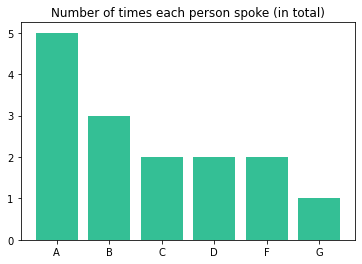

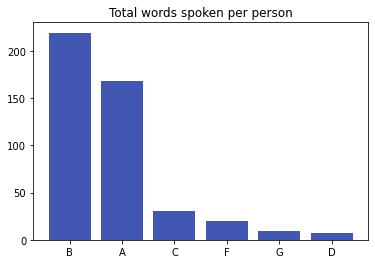

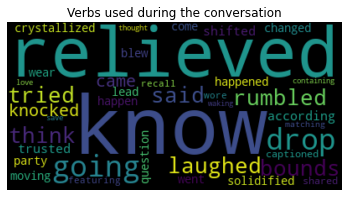

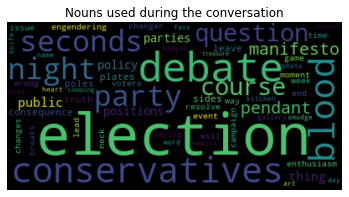

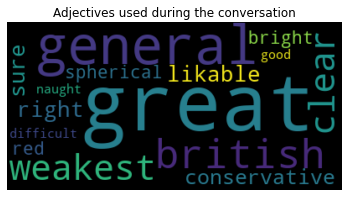

The 1st search term is "(77.5, '2003 -- famously wore matching oval pendants containing drops')"
The 2nd search term is "(16.0, 'corbin came across according')"
The 3rd search term is "(14.666666666666666, 'great british public rumbled')"
The 4th search term is "(13.266666666666666, 'first election debate go')"
The 5th search term is "(9.0, 'fans may recall')"


In [106]:
feedback(df)